In [194]:
PROJECT_PATH = '/home/swei20/AE/'

In [1]:
DATASET_PATH="/scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_5000_2"

In [40]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import h5py as h5

In [195]:
# Allow load project as module
sys.path.insert(0, PROJECT_PATH)

In [6]:
fn = os.path.join(DATASET_PATH, 'spectra.h5')

In [199]:
with h5.File(fn, 'r') as f:
#     cont=f["cont"][:,:,:,3,1,:]
#     cont_idx=f["cont_idx"][:,:,:,3,1]
#     flux=f["flux"][:,:,:,3,1,:]
#     flux_idx=f["flux_idx"][:,:,:,3,1]
#     cont=f["cont"][()]
#     cont_idx=f["cont_idx"][()]

#     flux=f["flux"][()]
#     flux_idx=f["flux_idx"][()]
    wave = f["wave"][()]
    

In [145]:
cont_all = cont[cont_idx]
# flux_all = flux[flux_idx]

In [214]:
idx_end = np.digitize(14000, wave)

In [222]:
wave_15404=wave[:idx_end]

In [218]:
len(wave15404)

15404

In [219]:
flux_15404 = flux_all[:, :idx_end]

In [220]:
flux_15404.shape

(116614, 15404)

In [221]:
cont_15404 = cont_all[:, :idx_end]

In [142]:
flux_all.shape

(116614, 16094)

In [15]:
flux0.shape

(6336, 16094)

In [223]:
def getspec_all(idx):
    return np.array([wave_15404, flux_15404[idx], cont_15404[idx]]).T

# def getspec_all(idx):
#     return np.array([wave, flux_all[idx], cont_all[idx]]).T

In [224]:
#------------------------------------------------------------
# create an np array with the indexes of the breakpoints in 
# the spectra,aligning them with the breaks in the continuum
#------------------------------------------------------------
def makeBreakpoints(w):
    #-------------------------------------------
    # determine the indices of the breakpoints
    # from the wavelengths in Angstroms
    #-------------------------------------------
    wmax = max(w)
    wpts = [3647,8207,14589]
    ii = [0]
    for p in wpts:
        if (p<=wmax):
            ix = np.argwhere(w>p).item(0)
            ii.append(ix)
    ii.append(len(w)-1)
    #--------------------------------------
    # create the set of steps in lambda
    # merge with the breakpoints and sort
    #--------------------------------------
    nbins = 64
    step = np.int(np.floor((max(ii)-min(ii))/(10*nbins)))*10    
    jj = list(range(min(ii),max(ii),step))
    jj = np.unique(ii+jj)
    #----------------------------------------------------
    # prune the breakpoints on both sides of the breaks
    #----------------------------------------------------
    for i in range(1,len(ii)-1): 
        ix = ii[i]
        jj = np.delete(jj,(np.abs(jj-ix)<step) & (jj != ix))

    return jj

#-----------------------------------------------------
# compute the low-resolution envelope of spectrum(n)
#-----------------------------------------------------

def getEnv(n, brk):
#     d = getspec(n)
    d = getspec_all(n)
    c = np.cumsum(d,axis=0)
    b = c[brk,:]
    db = np.diff(b,axis=0)
    dk = np.diff(brk)
    dd = (db.T/dk).T
    return dd

In [153]:
from tqdm import tqdm

In [226]:
bk = makeBreakpoints(wave_15404)

<ipython-input-224-0e57e0cab512>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  step = np.int(np.floor((max(ii)-min(ii))/(10*nbins)))*10


In [232]:
bk

array([    0,   240,   480,   720,   960,  1200,  1440,  1680,  1953,
        2400,  2640,  2880,  3120,  3360,  3600,  3840,  4080,  4320,
        4560,  4800,  5040,  5280,  5520,  5760,  6000,  6240,  6480,
        6720,  6960,  7200,  7440,  7680,  7920,  8160,  8400,  8640,
        8880,  9120,  9360,  9600, 10063, 10320, 10560, 10800, 11040,
       11280, 11520, 11760, 12000, 12240, 12480, 12720, 12960, 13200,
       13440, 13680, 13920, 14160, 14400, 14640, 14880, 15120, 15360,
       15403])

In [231]:
bk.shape

(64,)

In [227]:
dds = []
for n in tqdm(range(len(flux_15404))):
    dd = getEnv(n, brk=bk)
    dds.append(dd)

100%|██████████| 116614/116614 [00:26<00:00, 4393.44it/s]


In [228]:
dds = np.array(dds)

In [229]:
dds[0,:,0].shape

(63,)

In [230]:
len(dds)

116614

In [173]:
import h5py

In [247]:
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'flux_116kx63_small.h5')

In [190]:
flux755.shape

(755, 16094)

In [235]:
flux_15404.shape

(116614, 15404)

In [236]:
wave_15404

array([ 3000.2639,  3000.564 ,  3000.8643, ..., 13996.3662, 13997.7656,
       13999.166 ])

In [243]:
bk.shape

(64,)

In [248]:
with h5py.File(SZALAY_PATH, 'w') as f:
#     f.create_dataset('flux', data = flux_15404, shape=(116614, 15404))
    f.create_dataset('wave', data = wave_15404, shape=(15404,))
    f.create_dataset('flux_63', data = dds[:,:,1], shape=(116614, 63))
    f.create_dataset('wave_63', data = dds[0,:,0], shape=(63,))
    f.create_dataset('bk_63', data = bk, shape=(64,))   


In [237]:
dds[:,:,1].shape

(116614, 63)

In [200]:
wave.shape

(16094,)

In [174]:
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'mat_116kx62.h5')

In [179]:
with h5py.File(SZALAY_PATH, 'r') as f:
#     flux = f["flux"][()]
    wave = f["wave"][()]
    flux_63 = f["flux_63"][()]
    wave_63 = f["wave_63"][()]


In [182]:
flux.shape, wave.shape

((116614, 62), (62,))

In [198]:
wave.shape

(62,)

In [176]:
with h5py.File(SZALAY_PATH, 'a') as f:
    f.create_dataset('flux', data = dds[:,:,1], shape=(116614, 62))
    f.create_dataset('wave', data = dds[0,:,0], shape=(62,))

#     f.create_dataset('flux10kmm', data = flux10kmm)

In [203]:
bk.shape

(63,)

In [202]:
wave.shape

(16094,)

In [204]:
wave

array([ 3000.2639,  3000.564 ,  3000.8643, ..., 14996.2119, 14997.7109,
       14999.2109])

In [208]:
bk = makeBreakpoints(wave)
bk.shape

<ipython-input-207-0e57e0cab512>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  step = np.int(np.floor((max(ii)-min(ii))/(10*nbins)))*10


(63,)

In [209]:
bk

array([    0,   250,   500,   750,  1000,  1250,  1500,  1953,  2250,
        2500,  2750,  3000,  3250,  3500,  3750,  4000,  4250,  4500,
        4750,  5000,  5250,  5500,  5750,  6000,  6250,  6500,  6750,
        7000,  7250,  7500,  7750,  8000,  8250,  8500,  8750,  9000,
        9250,  9500,  9750, 10063, 10500, 10750, 11000, 11250, 11500,
       11750, 12000, 12250, 12500, 12750, 13000, 13250, 13500, 13750,
       14000, 14250, 14500, 14750, 15000, 15250, 15500, 15816, 16093])

63


<ipython-input-16-9998c97f700f>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  step = np.int(np.floor((max(ii)-min(ii))/(10*nbins)))*10


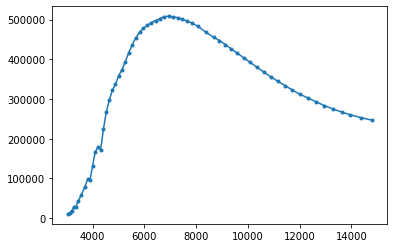

In [36]:
# for the full resolution spectra
#------------------------------------
# execute:
#  1. make the breakpoints
#  2. get the envelope for spectrum(3)
#  3. plot the course envelope
#------------------------------------
d = getspec(0)
wave = d[:,0]
bk = makeBreakpoints(wave)

e = getEnv(31, bk)
plt.plot(e[:,0],e[:,1],'.-');
print(len(bk))

In [38]:
#-------------------------------------------------------
# building a breakpoints array on the lo-res data
#-------------------------------------------------------
# ww = np.load('wave.npy')
ww=wave0
bk = makeBreakpoints(ww)
print(len(bk))
print(bk)

63
[    0   250   500   750  1000  1250  1500  1953  2250  2500  2750  3000
  3250  3500  3750  4000  4250  4500  4750  5000  5250  5500  5750  6000
  6250  6500  6750  7000  7250  7500  7750  8000  8250  8500  8750  9000
  9250  9500  9750 10063 10500 10750 11000 11250 11500 11750 12000 12250
 12500 12750 13000 13250 13500 13750 14000 14250 14500 14750 15000 15250
 15500 15816 16093]


<ipython-input-16-9998c97f700f>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  step = np.int(np.floor((max(ii)-min(ii))/(10*nbins)))*10


In [64]:
df_para = pd.read_csv("/home/swei20/AE/data/para.csv")

In [65]:
df_para

,Fe,Te,Lg,CM,OM,FeH,Teff,Logg,C_M,O_M,p1,p2,p3
0,0,0,0,1,0,-2.50,3500.0,0.0,-0.50,-0.25,-30.338438,2.195663,-5.001692
1,0,0,0,1,1,-2.50,3500.0,0.0,-0.50,0.00,-32.764657,2.281114,-5.436010
2,0,0,0,1,2,-2.50,3500.0,0.0,-0.50,0.25,-35.870359,2.474615,-5.925817
3,0,0,0,1,3,-2.50,3500.0,0.0,-0.50,0.50,-39.618324,2.673175,-6.343921
4,0,0,0,2,0,-2.50,3500.0,0.0,-0.25,-0.25,-31.107103,2.169074,-5.149027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116609,13,60,10,4,3,0.75,30000.0,5.0,0.25,0.50,-4.104047,-5.056857,1.422326
116610,13,60,10,5,0,0.75,30000.0,5.0,0.50,-0.25,-3.438580,-4.956540,1.236275
116611,13,60,10,5,1,0.75,30000.0,5.0,0.50,0.00,-3.618532,-4.968871,1.290465
116612,13,60,10,5,2,0.75,30000.0,5.0,0.50,0.25,-3.835860,-4.973086,1.356232


In [57]:
df_para.drop(df_para.columns[0], axis=1)

,Fe,Te,Lg,CM,OM,p1,p2,FeH,Teff,Logg,C_M,O_M,p3
0,0,0,0,1,0,-30.338438,2.195663,-2.50,3500.0,0.0,-0.50,-0.25,-5.001692
1,0,0,0,1,1,-32.764657,2.281114,-2.50,3500.0,0.0,-0.50,0.00,-5.436010
2,0,0,0,1,2,-35.870359,2.474615,-2.50,3500.0,0.0,-0.50,0.25,-5.925817
3,0,0,0,1,3,-39.618324,2.673175,-2.50,3500.0,0.0,-0.50,0.50,-6.343921
4,0,0,0,2,0,-31.107103,2.169074,-2.50,3500.0,0.0,-0.25,-0.25,-5.149027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116609,13,60,10,4,3,-4.104047,-5.056857,0.75,30000.0,5.0,0.25,0.50,1.422326
116610,13,60,10,5,0,-3.438580,-4.956540,0.75,30000.0,5.0,0.50,-0.25,1.236275
116611,13,60,10,5,1,-3.618532,-4.968871,0.75,30000.0,5.0,0.50,0.00,1.290465
116612,13,60,10,5,2,-3.835860,-4.973086,0.75,30000.0,5.0,0.50,0.25,1.356232


In [58]:
df_para.columns

Index(['Unnamed: 0', 'Fe', 'Te', 'Lg', 'CM', 'OM', 'p1', 'p2', 'FeH', 'Teff',
       'Logg', 'C_M', 'O_M', 'p3'],
      dtype='object')

In [61]:
df_para0 = df_para[['Fe', 'Te', 'Lg', 'CM', 'OM','FeH', 'Teff',
       'Logg', 'C_M', 'O_M', 'p1', 'p2',  'p3']]

In [63]:
df_para0.to_csv("/home/swei20/AE/data/para.csv", index=False)

0         False
1         False
2         False
3         False
4         False
          ...  
116609     True
116610     True
116611     True
116612     True
116613     True
Name: Teff, Length: 116614, dtype: bool

In [80]:
# FeH at -2.5, -1.5, -0.5 and 0, 
Fe_mask = (df_para["FeH"]==-2.5) | (df_para["FeH"]==-1.5) | (df_para["FeH"]==-0.5) | (df_para["FeH"]==0)
# Teff only in integer thousands (4000, 5000, etc), 
Te_mask = df_para["Teff"].map(lambda x: str(int(x))[-3:] == "000")
# all log_g values, and with O_M=C_M=0.
df_755 = df_para[Te_mask & Fe_mask & (df_para["C_M"]==0.0) & (df_para["O_M"]==0)]

In [184]:
df_para

,Fe,Te,Lg,CM,OM,FeH,Teff,Logg,C_M,O_M,p1,p2,p3
0,0,0,0,1,0,-2.50,3500.0,0.0,-0.50,-0.25,-30.338438,2.195663,-5.001692
1,0,0,0,1,1,-2.50,3500.0,0.0,-0.50,0.00,-32.764657,2.281114,-5.436010
2,0,0,0,1,2,-2.50,3500.0,0.0,-0.50,0.25,-35.870359,2.474615,-5.925817
3,0,0,0,1,3,-2.50,3500.0,0.0,-0.50,0.50,-39.618324,2.673175,-6.343921
4,0,0,0,2,0,-2.50,3500.0,0.0,-0.25,-0.25,-31.107103,2.169074,-5.149027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116609,13,60,10,4,3,0.75,30000.0,5.0,0.25,0.50,-4.104047,-5.056857,1.422326
116610,13,60,10,5,0,0.75,30000.0,5.0,0.50,-0.25,-3.438580,-4.956540,1.236275
116611,13,60,10,5,1,0.75,30000.0,5.0,0.50,0.00,-3.618532,-4.968871,1.290465
116612,13,60,10,5,2,0.75,30000.0,5.0,0.50,0.25,-3.835860,-4.973086,1.356232


In [188]:
flux755 = flux_all[df_755.index]

In [82]:
df_755.to_csv("/home/swei20/AE/data/para755.csv", index=False)

In [85]:
df_para0 = df_para [(df_para["C_M"]==0.0) & (df_para["O_M"]==0)]

In [87]:
df_para0["idx"] = np.arange(6336)

<ipython-input-87-fbdaf63dbcd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_para0["idx"] = np.arange(6336)


In [89]:
def get_mask(df_para):
    Fe_mask = (df_para["FeH"]==-2.5) | (df_para["FeH"]==-1.5) | (df_para["FeH"]==-0.5) | (df_para["FeH"]==0)
    # Teff only in integer thousands (4000, 5000, etc), 
    Te_mask = df_para["Teff"].map(lambda x: str(int(x))[-3:] == "000")
    return Fe_mask & Te_mask

In [90]:
mask = get_mask(df_para0)

In [94]:
idx755=df_para0[mask]["idx"].values

In [97]:
flux_755 = flux0[idx755]

In [98]:
cont_755 = cont0[idx755]

In [99]:
flux_755.shape

(755, 16094)

In [84]:
flux

(6336, 16094)

In [ ]:
e = getEnv(31, bk)
plt.plot(e[:,0],e[:,1],'.-');
print(len(bk))

In [100]:
def getspec755(idx):
    return np.array([wave0, flux_755[idx], cont_755[idx]]).T

In [103]:
bk.shape

(63,)

In [114]:
wave0.shape

(16094,)

In [115]:
# d = getspec(0)
# wave = d[:,0]
bk = makeBreakpoints(wave0)

<ipython-input-16-9998c97f700f>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  step = np.int(np.floor((max(ii)-min(ii))/(10*nbins)))*10


In [116]:
bk.shape

(63,)

In [107]:
def getEnv(n, brk=bk):
    d = getspec755(n)
    c = np.cumsum(d,axis=0)
    b = c[brk,:]
    db = np.diff(b,axis=0)
    dk = np.diff(brk)
    dd = (db.T/dk).T
    return dd

In [108]:
dds = []
for n in range(755):
    dd = getEnv(n)
    dds.append(dd)

In [111]:
dds = np.array(dds)

In [113]:
dd.shape

(62, 3)

In [112]:
dds.shape

(755, 62, 3)

In [110]:
len(dds)

755

In [119]:
dds[:,:,1].shape

(755, 62)

In [120]:
mat_755x62 = dds[:,:,1]

In [136]:
1

1

In [137]:
mat_755x62_wave = dds[0,:,0]

In [138]:
np.save("/home/swei20/AE/nb/wave_62",mat_755x62_wave)

In [128]:
np.save("/home/swei20/AE/nb/mat_755x62",mat_755x62)

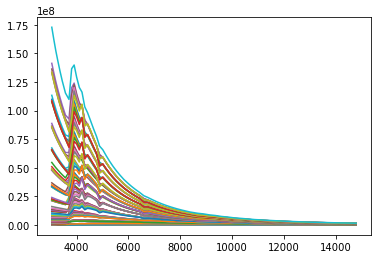

In [133]:
for i in range(100):
    plt.plot(dds[0,:,0], mat_755x62[i])

In [134]:
aa = np.load("/home/swei20/AE/nb/mat_755x62.npy")

In [135]:
aa.shape

(755, 62)

In [ ]:
(/home/swei20/AE/nb/mat_755x62")